# Receipt Scanning Tutorial

Initial Tutorial to give an idea as to what our product should output


### Strucutre of Example Project: 

|--> scan-receipt.ipynb (YOU ARE HERE) <br>
|--> whole_foods.png 



In [1]:
# Libraries
from PIL import Image
import cv2
import pytesseract
import argparse
import re 
import imutils
from imutils.perspective import four_point_transform


In [2]:
try:

    import Image

except ImportError:

    from PIL import Image

from pytesseract import *

print("TEST")
print(pytesseract.image_to_string(Image.open("C:\\Users\\Lenovo\\OneDrive\\Desktop\\Gaming\\bakiiii.jpg")))
print("TEST")

TEST

TEST


## Receipt Scanner Steps

1) Apply edge detection to reveal outline of receipt against background 
    * need sufficient contrast between background and receipt for this to work
2) Detect contours in edge map
3) Loop over contours and find largest contour with four vertices 
    * We do this because a receipt is rectangular and will always have four corners, ie: this pattern will always apply
4) Apply a perspective transform; yields birds-eye view of receipt 
    * improves OCR accuracy
5) Apply Tesseract OCR Engine with --psm 4 to the transformed photo 
    * Allows to read receipt line by line
6) Use regular expressions to parse out item price & name
7) Display results in print statement on terminal
    

In [5]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input receipt image")
ap.add_argument("-d", "--debug", type=int, default=-1,
	help="whether or not we are visualizing each step of the pipeline")
args = vars(ap.parse_args())


usage: ipykernel_launcher.py [-h] -i IMAGE [-d DEBUG]
ipykernel_launcher.py: error: the following arguments are required: -i/--image


SystemExit: 2

## Adjusting Canny Edge Detection

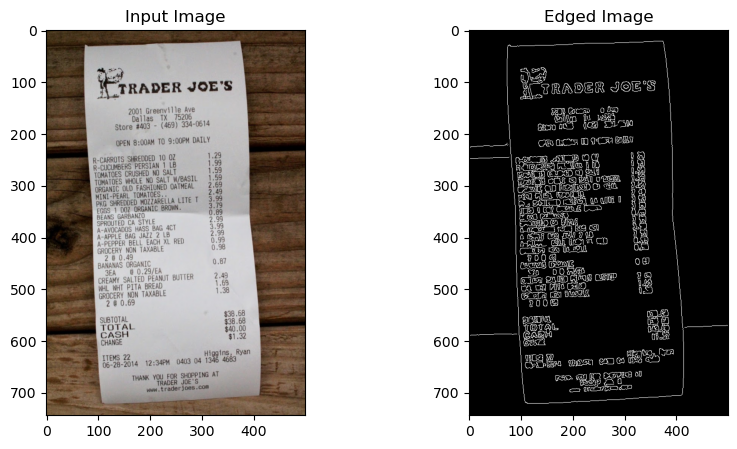

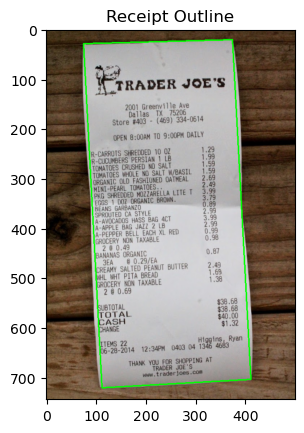

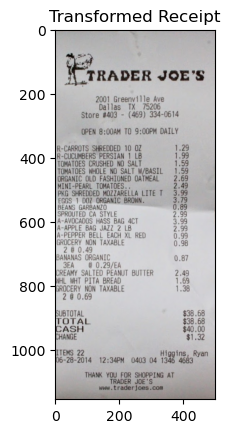

[INFO] raw output:
TRADER JOE’S

2001 Greenville Ave
Dallas 1X 75206
Store #403 - (469) 334-0614

OPEN 8:00AM TO 9:00PM DAILY

R-CARROTS SHREDDED 10 OZ 1,29
R-CUCUMBERS PERSIAN 1 LB 1.99
TOMATOES CRUSHED NO SALT 1,59

TOMATOES WHOLE NO SALT W/BASIL 1.59
ORGANIC OLD FASHIONED OATMEAL 2.69

MINI-PEARL TOMATOES. . 2.49
PKG SHREDDED MOZZARELLA LITE T 3.99
EGGS 1 DOZ ORGANIC BROWN. 3.79
BEANS GARBANZO 0.89
SPROUTED CA STYLE 2.09
A-AVOCADOS HASS BAG 4CT 3.99
A-APPLE BAG JAZZ 2 LB Oe
A-PEPPER BELL EACH XL RED 0.99
GROCERY NON TAXABLE 0.98

2 @ 0.49
BANANAS ORGANIC 0.87

3EA —@ 0.29/EA
CREAMY SALTED PEANUT BUTTER 2.49
WHL WHT PITA BREAD 1.69
GROCERY NON TAXABLE 1.38

2 6 0.69
SUBTOTAL $38.68
TOTAL $38.68
CASH $40.00
CHANGE $1.32

ITEMS 22 Higgins, Ryan
06-28-2014 12:34PM 0403 04 1346 46 my
THANK YOU FOR SHOPPING AT
TRADER JOE'S



[INFO] price line items:
R-CUCUMBERS PERSIAN 1 LB 1.99
TOMATOES WHOLE NO SALT W/BASIL 1.59
ORGANIC OLD FASHIONED OATMEAL 2.69
MINI-PEARL TOMATOES. . 2.49
PKG SHREDDE

In [71]:
#instead of term cmd, read directly from disk

# Libraries 

from PIL import Image
import cv2
import pytesseract
import re
import imutils
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt

# Instead of using argparse, manually set the image path and debug flag
image_path = "1.jpg"  # Change this to the path of your image
debug = 1  # Set to 1 for debug mode, otherwise 0

# Load the input image from disk, resize it, and compute the ratio
orig = cv2.imread(image_path)
image = orig.copy()
image = imutils.resize(image, width=500)
ratio = orig.shape[1] / float(image.shape[1])

# Convert the image to grayscale, blur it slightly, and apply edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edged = cv2.Canny(blurred, 30, 140, apertureSize=3, L2gradient=False)

# Display the input and edge-detected images if debug is enabled
if debug > 0:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(edged, cmap="gray")
    plt.title("Edged Image")
    plt.show()

# Find contours in the edge map and sort them by size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# Initialize a contour that corresponds to the receipt outline
receiptCnt = None

# Loop over the contours
for c in cnts:
    # Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # If our approximated contour has four points, then we can assume we found the outline
    if len(approx) == 4:
        receiptCnt = approx
        break

# If the receipt contour is empty, raise an exception
if receiptCnt is None:
    raise Exception("Could not find receipt outline. Try debugging edge detection and contour steps.")

# Display the contour if debug mode is enabled
if debug > 0:
    output = image.copy()
    cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Receipt Outline")
    plt.show()

# Apply a four-point perspective transform to the original image to get a top-down view
receipt = four_point_transform(orig, receiptCnt.reshape(4, 2) * ratio)

# Display the transformed receipt image
plt.imshow(cv2.cvtColor(imutils.resize(receipt, width=500), cv2.COLOR_BGR2RGB))
plt.title("Transformed Receipt")
plt.show()

# Apply OCR to the receipt image
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB), config=options)

# Show the raw OCR output
print("[INFO] raw output:")
print("==================")
print(text)
print("\n")

# Define a regular expression that will match line items with a price
pricePattern = r'([0-9]+\.[0-9]+)'

# Show the output of filtering out only the line items
print("[INFO] price line items:")
print("========================")
for row in text.split("\n"):
    if re.search(pricePattern, row) is not None:
        print(row)


## Dilating Edges

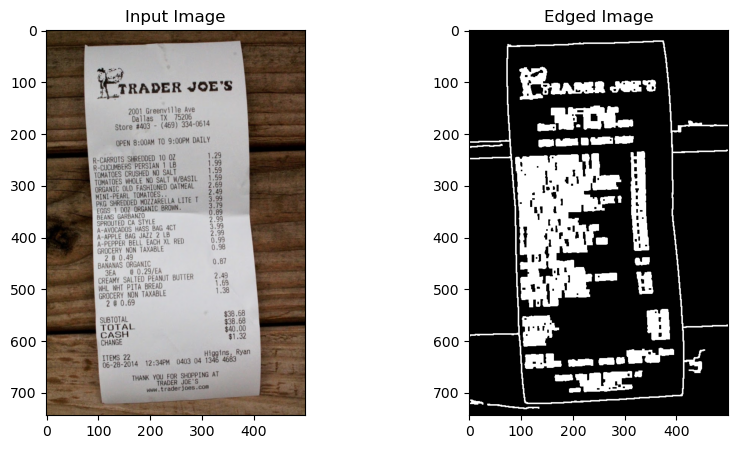

Exception: Could not find receipt outline. Try debugging edge detection and contour steps.

In [17]:
#instead of term cmd, read directly from disk

# Libraries
from PIL import Image
import cv2
import pytesseract
import re
import imutils
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt

# Instead of using argparse, manually set the image path and debug flag
image_path = "1.jpg"  # Change this to the path of your image
debug = 1  # Set to 1 for debug mode, otherwise 0

# Load the input image from disk, resize it, and compute the ratio
orig = cv2.imread(image_path)
image = orig.copy()
image = imutils.resize(image, width=500)
ratio = orig.shape[1] / float(image.shape[1])

# Convert the image to grayscale, blur it slightly, and apply edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 30, 150)
edged = cv2.dilate(edged, None, iterations=2)
edged = cv2.erode(edged, None, iterations=1)


# Display the input and edge-detected images if debug is enabled
if debug > 0:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(edged, cmap="gray")
    plt.title("Edged Image")
    plt.show()

# Find contours in the edge map and sort them by size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# Initialize a contour that corresponds to the receipt outline
receiptCnt = None

# Loop over the contours
for c in cnts:
    # Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # If our approximated contour has four points, then we can assume we found the outline
    if len(approx) == 4:
        receiptCnt = approx
        break

# If the receipt contour is empty, raise an exception
if receiptCnt is None:
    raise Exception("Could not find receipt outline. Try debugging edge detection and contour steps.")

# Display the contour if debug mode is enabled
if debug > 0:
    output = image.copy()
    cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Receipt Outline")
    plt.show()

# Apply a four-point perspective transform to the original image to get a top-down view
receipt = four_point_transform(orig, receiptCnt.reshape(4, 2) * ratio)

# Display the transformed receipt image
plt.imshow(cv2.cvtColor(imutils.resize(receipt, width=500), cv2.COLOR_BGR2RGB))
plt.title("Transformed Receipt")
plt.show()

# Apply OCR to the receipt image
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB), config=options)

# Show the raw OCR output
print("[INFO] raw output:")
print("==================")
print(text)
print("\n")

# Define a regular expression that will match line items with a price
pricePattern = r'([0-9]+\.[0-9]+)'

# Show the output of filtering out only the line items
print("[INFO] price line items:")
print("========================")
for row in text.split("\n"):
    if re.search(pricePattern, row) is not None:
        print(row)


## Filter based on Contour Aspect Ratio

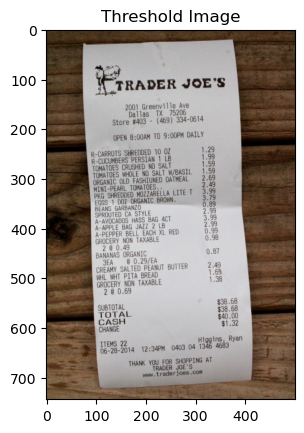

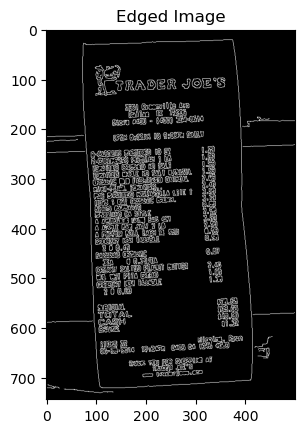

Exception: Could not find receipt outline. Try debugging edge detection and contour steps.

In [34]:
#instead of term cmd, read directly from disk

# Libraries
from PIL import Image
import cv2
import pytesseract
import re
import imutils
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt

# Instead of using argparse, manually set the image path and debug flag
image_path = "1.jpg"  # Change this to the path of your image
debug = 1  # Set to 1 for debug mode, otherwise 0

# Load the input image from disk, resize it, and compute the ratio
orig = cv2.imread(image_path)
image = orig.copy()
image = imutils.resize(image, width=500)
ratio = orig.shape[1] / float(image.shape[1])

# Convert the image to grayscale, blur it slightly, and apply edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply thresholding
# You can experiment with different types of thresholding methods here
thresh = cv2.threshold(blurred, 200, 1000, cv2.THRESH_BINARY)[1]


# Display the input and edge-detected images if debug is enabled
if debug > 0:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Threshold Image")
    plt.show()

edged = cv2.Canny(blurred, 30, 150)

# Display edge-detected image (if in debug )

if debug > 0:
    plt.imshow(edged, cmap="gray")
    plt.title("Edged Image")
    plt.show()

# Find contours in the edge map and sort them by size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

# Initialize a contour that corresponds to the receipt outline
receiptCnt = None

# Loop over the contours
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        aspectRatio = w / float(h)
        
        # Filter out contours with an unrealistic aspect ratio for a receipt
        if 0.5 < aspectRatio < 2.0:
            receiptCnt = approx
            break


# If the receipt contour is empty, raise an exception
if receiptCnt is None:
    raise Exception("Could not find receipt outline. Try debugging edge detection and contour steps.")

# Display the contour if debug mode is enabled
if debug > 0:
    output = image.copy()
    cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.title("Receipt Outline")
    plt.show()

# Apply a four-point perspective transform to the original image to get a top-down view
receipt = four_point_transform(orig, receiptCnt.reshape(4, 2) * ratio)

# Display the transformed receipt image
plt.imshow(cv2.cvtColor(imutils.resize(receipt, width=500), cv2.COLOR_BGR2RGB))
plt.title("Transformed Receipt")
plt.show()

# Apply OCR to the receipt image
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB), config=options)

# Show the raw OCR output
print("[INFO] raw output:")
print("==================")
print(text)
print("\n")

# Define a regular expression that will match line items with a price
pricePattern = r'([0-9]+\.[0-9]+)'

# Show the output of filtering out only the line items
print("[INFO] price line items:")
print("========================")
for row in text.split("\n"):
    if re.search(pricePattern, row) is not None:
        print(row)


Load sample image and perform noise reduction (by resizing image)

In [ ]:
# load the input image from disk, resize it, and compute the ratio
# of the *new* width to the *old* width
orig = cv2.imread(args["image"])
image = orig.copy()
image = imutils.resize(image, width=500)
ratio = orig.shape[1] / float(image.shape[1])

Edge detection to find receipt in image <br>

Grey scale & blur 

In [ ]:
# convert the image to grayscale, blur it slightly, and then apply
# edge detection
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)
# check to see if we should show the output of our edge detection
# procedure
if args["debug"] > 0:
	cv2.imshow("Input", image)
	cv2.imshow("Edged", edged)
	cv2.waitKey(0)

get contours from processed image

In [ ]:
# find contours in the edge map and sort them by size in descending
# order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

find contour with 4 vertices (receipt contours)

In [ ]:
# initialize a contour that corresponds to the receipt outline
receiptCnt = None
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if our approximated contour has four points, then we can
	# assume we have found the outline of the receipt
	if len(approx) == 4:
		receiptCnt = approx
		break
# if the receipt contour is empty then our script could not find the
# outline and we should be notified
if receiptCnt is None:
	raise Exception(("Could not find receipt outline. "
		"Try debugging your edge detection and contour steps."))

get birds eye view of receipt

In [ ]:
# check to see if we should draw the contour of the receipt on the
# image and then display it to our screen
if args["debug"] > 0:
	output = image.copy()
	cv2.drawContours(output, [receiptCnt], -1, (0, 255, 0), 2)
	cv2.imshow("Receipt Outline", output)
	cv2.waitKey(0)
# apply a four-point perspective transform to the *original* image to
# obtain a top-down bird's-eye view of the receipt
receipt = four_point_transform(orig, receiptCnt.reshape(4, 2) * ratio)
# show transformed image
cv2.imshow("Receipt Transform", imutils.resize(receipt, width=500))
cv2.waitKey(0)

Apply OCR

In [ ]:
# apply OCR to the receipt image by assuming column data, ensuring
# the text is *concatenated across the row* (additionally, for your
# own images you may need to apply additional processing to cleanup
# the image, including resizing, thresholding, etc.)
options = "--psm 4"
text = pytesseract.image_to_string(
	cv2.cvtColor(receipt, cv2.COLOR_BGR2RGB),
	config=options)
# show the raw output of the OCR process
print("[INFO] raw output:")
print("==================")
print(text)
print("\n")

define and use regular expression pattern that will match line items that include price component

In [ ]:
# define a regular expression that will match line items that include
# a price component
pricePattern = r'([0-9]+\.[0-9]+)'
# show the output of filtering out *only* the line items in the
# receipt
print("[INFO] price line items:")
print("========================")
# loop over each of the line items in the OCR'd receipt
for row in text.split("\n"):
	# check to see if the price regular expression matches the current
	# row
	if re.search(pricePattern, row) is not None:
		print(row)